In [1]:
!python -m pip install -r requirements.txt -q
%load_ext pep8magic
%matplotlib inline
# standard
import csv
import codecs
import glob
import json
import os
import re
import time
# 3rd-party
import matplotlib.pyplot as plt
import pandas as pd
import pytablewriter
import requests_oauthlib
from scipy import stats
# self-made
from conf import *

Loading extensions from ~/.ipython/extensions is deprecated. We recommend managing extensions like any other Python packages, in site-packages.


/home/eggplants/.pyenv/versions/3.9.2/lib/python3.9/site-packages/pep8.py:110: FutureWarning: Possible nested set at position 1
  EXTRANEOUS_WHITESPACE_REGEX = re.compile(r'[[({] | []}),;:]')
/home/eggplants/.pyenv/versions/3.9.2/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
"""
read raw csv
file is obtained by Twitter Media Downloader
https://memo.furyutei.work/entry/20160723/1469282864
"""
# read the latest file in the csv folder
dir_ = sorted(glob.glob('./CSV/*/'))[-1]
file = glob.glob(dir_+'*dryrun.csv')[0]
c_d = ""
with codecs.open(file, "r", "utf-8", "ignore") as f:
    c_d = pd.read_csv(f,
                      parse_dates=['Tweet date'],
                      # skiprows=[0, 1, 2, 3]
                      skiprows=[0, 1, 2, 3, 4])
c_d

,Tweet date,Action date,Display name,Username,Tweet URL,Media type,Media URL,Saved filename,Remarks,Tweet content,Replies,Retweets,Likes
0,2021-08-09 18:42:00,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/14246...,No media,NaN,NaN,NaN,█▇▆▅▄▃▂▁ （’ω’） ▁▂▃▄▅▆▇█ https://twitter.com/Sh...,NaN,1.0,2.0
1,2021-08-09 17:35:54,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/14246...,Image,https://pbs.twimg.com/media/E8VgM76VcAM_ip3?fo...,minyoruminyon-1424650634142240773-20210809_173...,NaN,https://twitter.com/Sheeeeepla/status/14246506...,NaN,NaN,6.0
2,2021-08-09 17:13:12,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/14246...,No media,NaN,NaN,NaN,マイヤヒ〜ｗｗｗ\nマイヤフ〜ｗｗｗ\nマイヤハ〜ｗｗｗ\nマイヤハッハー〜ｗｗｗ http...,NaN,1.0,3.0
3,2021-08-09 16:57:18,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/14246...,Image,https://pbs.twimg.com/media/E8VXXhyVgAIm-P3?fo...,minyoruminyon-1424640921165918212-20210809_165...,NaN,https://twitter.com/Sheeeeepla/status/14246408...,NaN,5.0,20.0
4,2021-08-09 16:38:27,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/14246...,No media,NaN,NaN,NaN,ちちちちちちちちち㌨\nちちちちちちちち㌨ち\nちちちちちちち㌨ちち\nちちちちちち㌨ちちち...,NaN,21.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32164,2019-07-16 18:55:27,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/11510...,No media,NaN,NaN,NaN,＿人人人人人人人人人人人人人＿\n＞ そりすぎてソリになった ＜\n￣Y^Y^Y^Y^Y^Y...,NaN,1.0,2.0
32165,2019-07-16 18:54:17,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/11510...,Image,https://pbs.twimg.com/media/D_lpz_8UcAAtuyr?fo...,minyoruminyon-1151067523225288706-20190716_185...,NaN,https://twitter.com/kya_ski/status/11510674762...,NaN,NaN,1.0
32166,2019-07-16 18:53:51,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/11510...,Image,https://pbs.twimg.com/media/D_lpthDUwAA7zXX?fo...,minyoruminyon-1151067412189466625-20190716_185...,NaN,https://twitter.com/gorilla_5756/status/115106...,NaN,NaN,NaN
32167,2019-07-16 18:52:35,NaN,シェル芸bot,@minyoruminyon,https://twitter.com/minyoruminyon/status/11510...,No media,NaN,NaN,NaN,/usr/bin/lua5.3\n/usr/bin/zsh https://twitter....,NaN,NaN,NaN


In [3]:
# fetch tweeted user from tweet link URL by API
"""
statuses/show/:id ツイートid1つから取得
900tweet/15m
(wait: /1req)
処理簡単

statuses/lookup ツイートid100つから取得
30000tweet/15m
処理複雑(そうでもない)
"""


def getUser(url, twitter):
    params = {
        'id': re.search(r'^(\d+)', url[::-1]).groups()[0][::-1],
        'trim_user': 'false',
        'include_my_retweet': 'false',
        'include_entities': 'true',
    }
    while True:
        req = twitter.get('https://api.twitter.com/1.1/statuses/show.json',
                          params=params)
        time.sleep(1)
        if req.status_code == 200:
            j = json.loads(req.text)
            try:
                return j['quoted_status']['user']['screen_name']
            except KeyError:
                """
                estimate from the URL in tweet
                when the quoted tweet has been deleted (Reliability: low)
                """
                urls = [u['expanded_url'] for u in j['entities']['urls']]
                cand = [re.search(r'https://twitter.com/([^/]+)/status/\d+',
                                  u) for u in urls]
                cand = [t.groups(1)[0] for t in cand if t]
                if cand:
                    return cand[0]
                else:
                    return 'minyoruminyon'
        else:
            continue


In [4]:
# make formatted.csv
newcsv = {'Date': c_d['Tweet date'],
          'URL': c_d['Tweet URL'],
          'User': [],
          'R+L': c_d['Retweets'].fillna(0) + c_d['Likes'].fillna(0),
          'Retweets': c_d['Retweets'],
          'Likes': c_d['Likes'],
          'm': c_d['Tweet content']
         }

# estimate one specific user posted a tweet
# which was RT'd by @minyoruminyon
twitter = requests_oauthlib.OAuth1Session(CK, CS, t_AT, AS)
i, cnt, lineno = 0, 0, len(c_d)
for l in [[k, v] for k, v in zip(newcsv['URL'], newcsv['m'])]:
    i += 1
    user = re.findall(
        r'https://twitter.com/([a-zA-Z0-9_]+)/status/[0-9]+',
        l[1])
    user = list(set(user)-set(['minyoruminyon']))
    print("%05d/%d:%s..." % (i, lineno, str(user)[0:35]),
          " " * 50, end="\r")
    if not user:
        user = 'minyoruminyon'
    else:
        if user == ['minyoruminyon']:
            user = 'minyoruminyon'
        elif len(user) == 1:
            user = user[0]
        else:
            user = getUser(l[0], twitter)
            cnt += 1
            time.sleep(1)
    newcsv['User'].append(user)
print("Process Ended.(about: %ds, line: %d)" %(cnt + 1, lineno))
newcsv.pop('m')
pd.DataFrame(newcsv).fillna(0).to_csv(dir_+'formatted.csv', index=None)
pd.read_csv(dir_ + 'formatted.csv')

02034/32169:['ryuichiueda']...

03022/32169:['hiramasun']...                                                   

04818/32169:['shishimy']...                                                   

05523/32169:['Sheeeeepla']... 

07887/32169:['Sheeeeepla']...

08661/32169:['flip_flop_555']...                                                   

09487/32169:['SoukouTalkyou']...                                                   

11246/32169:['yami_buta']...

Process Ended.(about: 14s, line: 32169)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    


,Date,URL,User,R+L,Retweets,Likes
0,2021-08-09 18:42:00,https://twitter.com/minyoruminyon/status/14246...,Sheeeeepla,3.0,1.0,2.0
1,2021-08-09 17:35:54,https://twitter.com/minyoruminyon/status/14246...,Sheeeeepla,6.0,0.0,6.0
2,2021-08-09 17:13:12,https://twitter.com/minyoruminyon/status/14246...,Sheeeeepla,4.0,1.0,3.0
3,2021-08-09 16:57:18,https://twitter.com/minyoruminyon/status/14246...,Sheeeeepla,25.0,5.0,20.0
4,2021-08-09 16:38:27,https://twitter.com/minyoruminyon/status/14246...,eban,53.0,21.0,32.0
...,...,...,...,...,...,...
32164,2019-07-16 18:55:27,https://twitter.com/minyoruminyon/status/11510...,figyuuuuuu,3.0,1.0,2.0
32165,2019-07-16 18:54:17,https://twitter.com/minyoruminyon/status/11510...,kya_ski,1.0,0.0,1.0
32166,2019-07-16 18:53:51,https://twitter.com/minyoruminyon/status/11510...,gorilla_5756,0.0,0.0,0.0
32167,2019-07-16 18:52:35,https://twitter.com/minyoruminyon/status/11510...,qwertanus,0.0,0.0,0.0


In [5]:
# read formatted.csv
f_d = pd.read_csv(dir_+'formatted.csv')
# make user.csv
userdata = []
c = 1
tmp = None
for k, v in f_d['User'].value_counts().items():
    if tmp != v:
        c += 1
    if not tmp:
        tmp = v
    tmp = v
    userdata.append([c-1, k, v])
with open(dir_+'user.csv', 'w') as f:
    w = csv.writer(f)
    w.writerow(['Rank', 'User', 'Count'])
    w.writerows(userdata)
pd.read_csv(dir_+'user.csv')

,Rank,User,Count
0,1,jiro_saburomaru,5189
1,2,egpl0,3093
2,3,yami_buta,2522
3,4,qwertanus,2209
4,5,Sheeeeepla,1072
...,...,...,...
1037,112,TheNamesSpike,1
1038,112,Bi2Sho,1
1039,112,YES_SAMA_SHEET,1
1040,112,370kum,1


In [6]:
# make buzz.csv
buzz = f_d.sort_values('R+L', ascending=False)
buzz.to_csv(dir_+'buzz.csv', index=None)
# reindex
buzz = pd.read_csv(dir_+'buzz.csv')
buzz.index = buzz.index + 1
buzz.to_csv(dir_+'buzz.csv')
buzz[0:1000].to_csv(dir_+'buzz_1000.csv')
pd.read_csv(dir_+'buzz_1000.csv')

,Unnamed: 0,Date,URL,User,R+L,Retweets,Likes
0,1,2020-01-28 09:02:17,https://twitter.com/minyoruminyon/status/12219...,yami_buta,4155.0,1371.0,2784.0
1,2,2020-04-02 22:32:26,https://twitter.com/minyoruminyon/status/12457...,yami_buta,1202.0,452.0,750.0
2,3,2021-06-26 21:43:08,https://twitter.com/minyoruminyon/status/14087...,donnay1224,1176.0,354.0,822.0
3,4,2020-08-25 17:55:54,https://twitter.com/minyoruminyon/status/12981...,3socha,1172.0,466.0,706.0
4,5,2020-08-14 10:46:22,https://twitter.com/minyoruminyon/status/12940...,Sheeeeepla,1136.0,353.0,783.0
...,...,...,...,...,...,...,...
995,996,2020-01-28 14:18:34,https://twitter.com/minyoruminyon/status/12220...,egpl0,19.0,3.0,16.0
996,997,2021-06-28 12:51:50,https://twitter.com/minyoruminyon/status/14093...,rabdology,19.0,8.0,11.0
997,998,2020-09-11 08:31:39,https://twitter.com/minyoruminyon/status/13042...,yami_buta,19.0,6.0,13.0
998,999,2020-05-15 21:46:16,https://twitter.com/minyoruminyon/status/12612...,Sample____1,19.0,3.0,16.0


In [7]:
# by month
t = pd.read_csv(dir_+'formatted.csv')
t['Date'] = pd.to_datetime(t['Date'])
bymonth = []
for y in t['Date'].dt.year.unique()[::-1]:
    for m in range(1, 13):
        bymonth.append(["%d/%d" % (y, m),
                       len(t[(t['Date'].dt.year == y) &
                             (t['Date'].dt.month == m)])])
with open(dir_+'month.csv', 'w') as f:
    w = csv.writer(f)
    [w.writerow(i) for i in bymonth]
pd.read_csv(dir_+'month.csv')

,2019/1,0
0,2019/2,0
1,2019/3,0
2,2019/4,0
3,2019/5,0
4,2019/6,0
5,2019/7,2868
6,2019/8,3507
7,2019/9,1575
8,2019/10,2042
9,2019/11,1008


In [8]:
# by hour
t = pd.read_csv(dir_+'formatted.csv')
t['Date'] = pd.to_datetime(t['Date'])
byhour = []
for h in range(0, 24):
    byhour.append(["%02d" % h,
                  len(t[(t['Date'].dt.hour == h)])])
with open(dir_+'hour.csv', 'w') as f:
    w = csv.writer(f)
    [w.writerow(i) for i in byhour]
pd.read_csv(dir_+'hour.csv')

,00,1559
0,1,1127
1,2,703
2,3,477
3,4,376
4,5,320
5,6,478
6,7,741
7,8,1056
8,9,1108
9,10,1436


In [9]:
# extract some user's one
try:
    os.makedirs(dir_+'/user/')
except FileExistsError:
    pass


def extractUser(target):
    n = dir_+'/user/%s.csv' % target
    a = pd.read_csv(dir_ + 'formatted.csv')
    a[(a['User'] == target)].to_csv(n, index=False)
    pd.read_csv(n).to_csv(n)
    return pd.read_csv(n)

u = pd.read_csv(dir_ + 'user.csv')
for t in u[(u['Count'] > 9)]['User']:
    print(t, '            ', end="\r")
    extractUser(t)
print('========END========')

========END========         


In [11]:
u = pd.read_csv(dir_+'user.csv')
print(len(u),
      len(u[(u['Count'] > 9)]))

1042 288


In [12]:
# make user.md
writer = pytablewriter.MarkdownTableWriter()
writer.from_dataframe(
    u.replace({'User': r'([0-9_a-zA-Z]+)'},
              {'User': r'[\1](https://twitter.com/\1)'}, regex=True))
writer.dump(dir_+"user.md")
writer.write_table()

|Rank|                         User                         |Count|
|---:|------------------------------------------------------|----:|
|   1|[jiro_saburomaru](https://twitter.com/jiro_saburomaru)| 5189|
|   2|[egpl0](https://twitter.com/egpl0)                    | 3093|
|   3|[yami_buta](https://twitter.com/yami_buta)            | 2522|
|   4|[qwertanus](https://twitter.com/qwertanus)            | 2209|
|   5|[Sheeeeepla](https://twitter.com/Sheeeeepla)          | 1072|
|   6|[rs_pferd](https://twitter.com/rs_pferd)              |  894|
|   7|[blacknon_](https://twitter.com/blacknon_)            |  803|
|   8|[RandomWeekday](https://twitter.com/RandomWeekday)    |  478|
|   9|[rokkaku_tenchi](https://twitter.com/rokkaku_tenchi)  |  477|
|  10|[P5mEm](https://twitter.com/P5mEm)                    |  468|
|  11|[eban](https://twitter.com/eban)                      |  453|
|  12|[shishimy](https://twitter.com/shishimy)              |  380|
|  13|[grethlen](https://twitter.com/grethlen)  

In [ ]:
# make buzz.md
writer = pytablewriter.MarkdownTableWriter()
b = pd.read_csv(dir_+'buzz.csv').replace(
            {'User':r'([0-9_a-zA-Z]+)'}, 
            {'User':r'[\1](https://twitter.com/\1)'},regex=True
    ).replace(
            {'URL':r'(^.*$)'}, 
            {'URL':r'[\1](\1)'},regex=True
    )
writer.from_dataframe(b)
writer.dump(dir_+"buzz.md")
writer.from_dataframe(b[0:1000])
writer.dump(dir_+"buzz_1000.md")
writer.from_dataframe(b[0:500])
writer.dump(dir_+"buzz_500.md")
writer.from_dataframe(b[0:100])
writer.dump(dir_+"buzz_100.md")
writer.write_table()

In [13]:
# make graphs
def showgraph(name, title, xlabel, ylim, dir_):
    f = [i.split(',') for i in open(name).readlines()]
    x, y = [], []
    for i in f:
        x.append(i[0])
        y.append(int(i[1]))

    plt.figure(figsize=(10, 10), dpi=100)
    plt.xlim(0, len(x)-1)
    plt.ylim(0, ylim)
    plt.grid(color='gray')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('tweet(s)')
    plt.plot(x, y)
    plt.xticks(rotation=90)
    plt.savefig(dir_ + title + '.png')

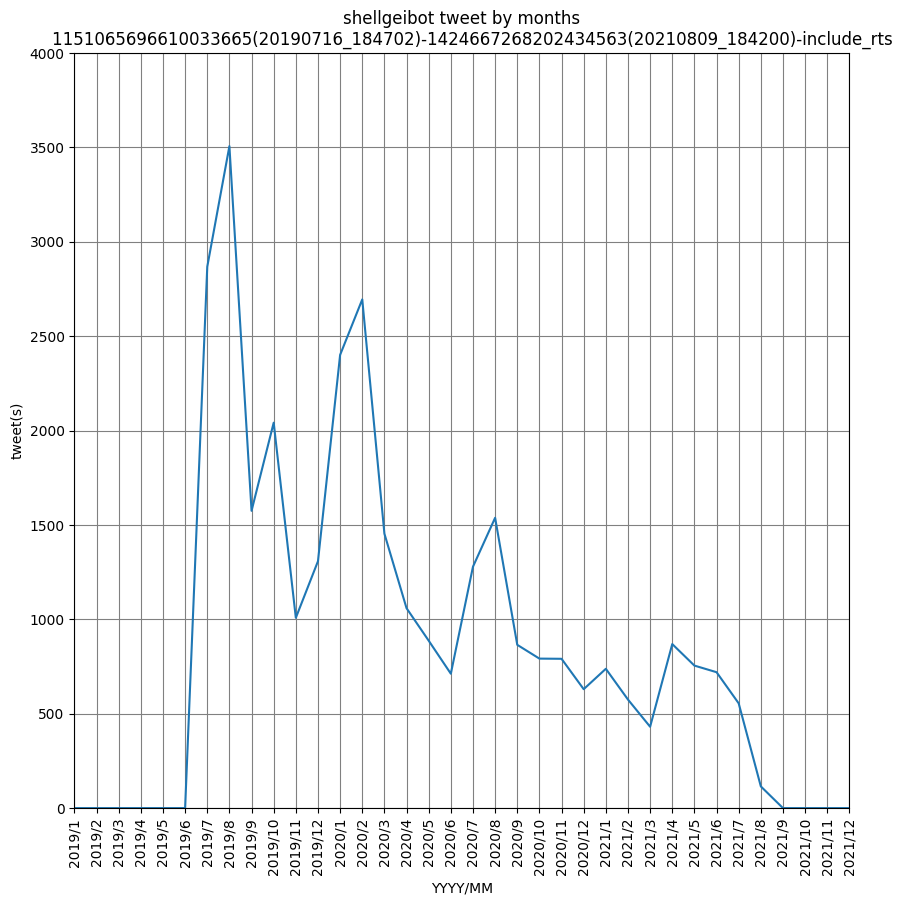

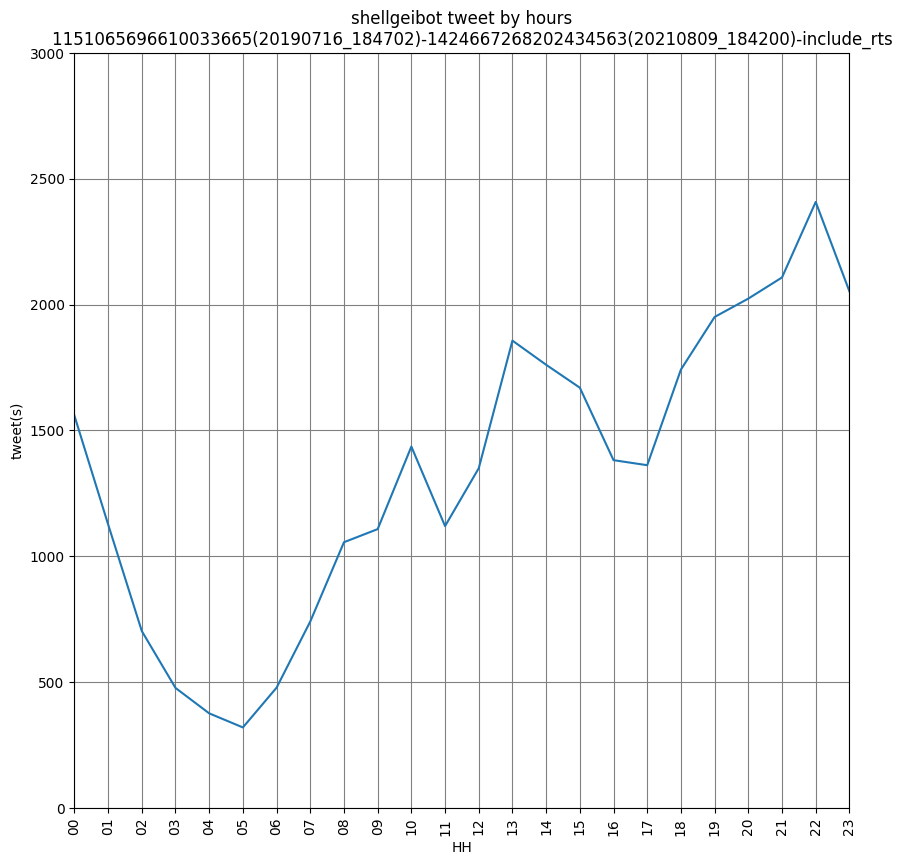

In [14]:
showgraph(
    dir_+"month.csv",
    """shellgeibot tweet by months
    %s""" % (file[49:][:-11]),
    "YYYY/MM",
    4000,
    dir_
)
showgraph(
    dir_+"hour.csv",
    """shellgeibot tweet by hours
    %s""" % (file[49:][:-11]),
    "HH",
    3000,
    dir_
)